In [1]:
import torch
import pandas as pd
import numpy as np

data = torch.load('processed_data.pt')

train_tabular_tensor = data['train_tabular']
train_price_tensor = data['train_prices']
train_image_tensor = data['train_images']
test_tabular_tensor = data['test_tabular']
test_image_tensor = data['test_images']
scaler = data['scaler']
encoder = data['encoder']
feature_names = data['train_tabular_cols']

print(f"Train tabular: {train_tabular_tensor.shape}")
print(f"Train prices: {train_price_tensor.shape}")
print(f"Train images: {train_image_tensor.shape}")
print(f"Test tabular: {test_tabular_tensor.shape}")
print(f"Test images: {test_image_tensor.shape}")

train_tabular_df = pd.DataFrame(
    train_tabular_tensor.numpy(),
    columns=feature_names
)
train_tabular_df['price'] = train_price_tensor.numpy().flatten()

test_tabular_df = pd.DataFrame(
    test_tabular_tensor.numpy(),
    columns=feature_names
)

print("\nFirst 5 rows train:")
print(train_tabular_df.head())

print("\nFirst 5 rows test:")
print(test_tabular_df.head())

/var/folders/1w/21hyyrjd3dz0j4q2zv96_zkc0000gn/T/ipykernel_24122/1123502235.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('processed_data.pt')


Train tabular: torch.Size([16209, 17])
Train prices: torch.Size([16209, 1])
Train images: torch.Size([16110, 3, 224, 224])
Test tabular: torch.Size([5404, 17])
Test images: torch.Size([5396, 3, 224, 224])

First 5 rows train:
   bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront      view  \
0  0.677402   0.178963    -0.290276 -0.144952  0.922943   -0.083788 -0.306964   
1 -0.394132   0.505667    -0.521813 -0.311135  0.922943   -0.083788 -0.306964   
2  0.677402   0.505667    -0.389506 -0.160457  0.922943   -0.083788 -0.306964   
3 -1.465666   0.178963    -0.918734 -0.364787  0.922943   -0.083788 -0.306964   
4 -0.394132  -0.147741    -0.874632 -0.038936 -0.918626   -0.083788 -0.306964   

   condition     grade  sqft_above  sqft_basement   zipcode  sqft_living15  \
0  -0.626000 -0.557611    0.030720      -0.657843 -0.269415      -0.473911   
1   0.908842 -0.557611   -0.224818      -0.657843 -0.842519      -0.385919   
2  -0.626000  0.296350   -0.078796      -0.657843 -1.

In [2]:
train_tabular_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,age,is_renovated,years_since_renovation,price
0,0.677402,0.178963,-0.290276,-0.144952,0.922943,-0.083788,-0.306964,-0.626000,-0.557611,0.030720,-0.657843,-0.269415,-0.473911,-0.129791,0.345663,-0.20797,-0.183085,268643.0
1,-0.394132,0.505667,-0.521813,-0.311135,0.922943,-0.083788,-0.306964,0.908842,-0.557611,-0.224818,-0.657843,-0.842519,-0.385919,-0.339019,-0.709771,-0.20797,-0.183085,245000.0
2,0.677402,0.505667,-0.389506,-0.160457,0.922943,-0.083788,-0.306964,-0.626000,0.296350,-0.078796,-0.657843,-1.728225,-0.165941,-0.196068,-0.777864,-0.20797,-0.183085,200000.0
3,-1.465666,0.178963,-0.918734,-0.364787,0.922943,-0.083788,-0.306964,-0.626000,-0.557611,-0.772399,-0.452638,-1.050920,-1.089851,-0.445025,-1.288558,-0.20797,-0.183085,352499.0
4,-0.394132,-0.147741,-0.874632,-0.038936,-0.918626,-0.083788,-0.306964,-0.626000,-0.557611,-0.614209,-0.657843,-0.477816,-0.576568,-0.173196,-0.777864,-0.20797,-0.183085,232000.0


In [3]:
test_tabular_df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,age,is_renovated,years_since_renovation
0,0.677402,0.178963,-0.003610,-0.153889,0.922943,-0.083788,-0.306964,0.908842,0.296350,0.347100,-0.657843,-0.165214,0.596652,-0.186971,-0.505493,-0.20797,-0.183085
1,1.748936,1.159075,0.911513,-0.209601,-0.918626,-0.083788,-0.306964,2.443684,0.296350,0.055057,1.781819,0.720492,0.567322,-0.239585,-0.199077,-0.20797,-0.183085
2,0.677402,0.505667,1.870739,-0.102375,0.922943,-0.083788,2.313829,-0.626000,2.858233,2.415742,-0.657843,-1.571924,2.532465,-0.113268,-0.880002,-0.20797,-0.183085
3,-0.394132,1.812483,2.741760,-0.006688,0.922943,-0.083788,2.313829,-0.626000,3.712194,3.377051,-0.657843,-0.686218,3.031084,0.055340,-0.641678,-0.20797,-0.183085
4,-0.394132,0.505667,0.525618,-0.244476,0.922943,-0.083788,-0.306964,-0.626000,1.150311,0.931187,-0.657843,-0.373616,0.391339,-0.322496,-1.118326,-0.20797,-0.183085


Sample train images:


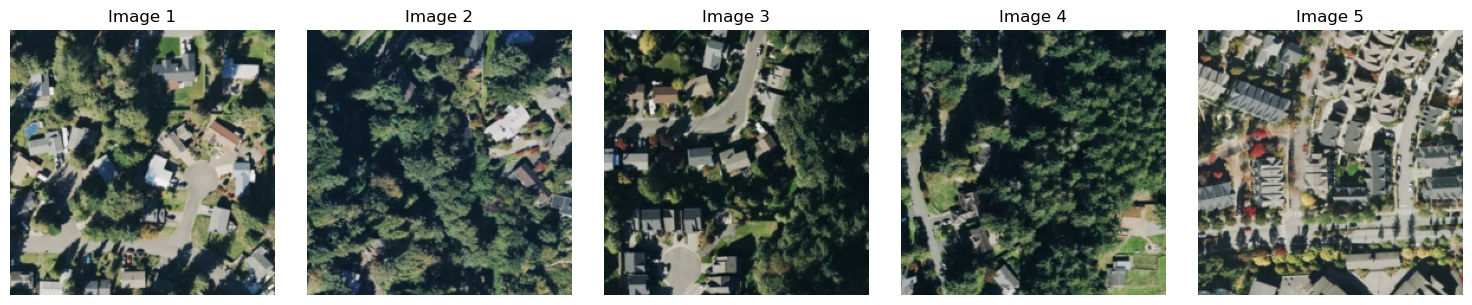

Sample test images:


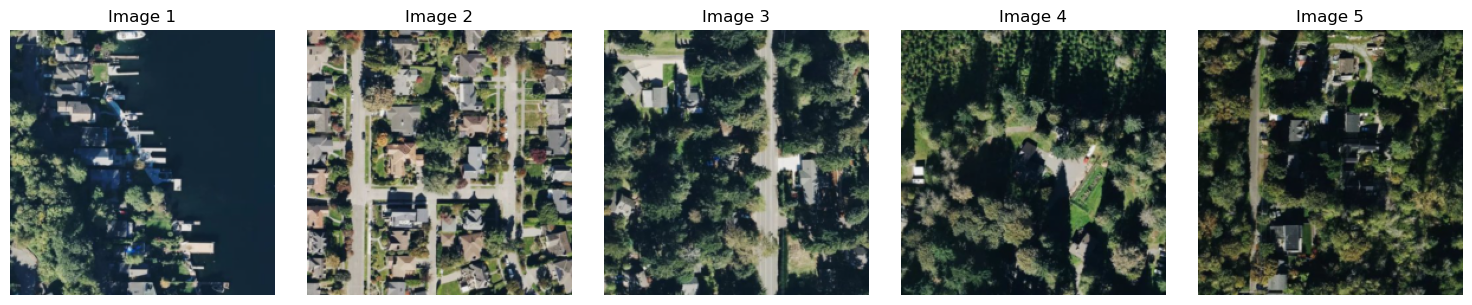

In [4]:
import matplotlib.pyplot as plt

def show_images(image_tensor, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    
    for i in range(n):
        img = image_tensor[i]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np, 0, 1)
        
        axes[i].imshow(img_np)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")
    
    plt.tight_layout()
    plt.show()

print("Sample train images:")
show_images(train_image_tensor)

if test_image_tensor is not None:
    print("Sample test images:")
    show_images(test_image_tensor)

In [5]:
# CELL 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [6]:
# CELL 3: Trim to Matching Pairs
train_size = min(train_tabular_tensor.shape[0], train_image_tensor.shape[0])
test_size = min(test_tabular_tensor.shape[0], test_image_tensor.shape[0])

train_tabular = train_tabular_tensor[:train_size]
train_images = train_image_tensor[:train_size]
train_prices = train_price_tensor[:train_size]

test_tabular = test_tabular_tensor[:test_size]
test_images = test_image_tensor[:test_size]

print(f"Aligned Train: {train_tabular.shape[0]} properties, {train_images.shape[0]} images")
print(f"Aligned Test: {test_tabular.shape[0]} properties, {test_images.shape[0]} images")

Aligned Train: 16110 properties, 16110 images
Aligned Test: 5396 properties, 5396 images


In [7]:
# CELL 3.5: Log-transform prices (ADD THIS BETWEEN CELL 3 AND 4)
import numpy as np

print(f"Price stats before log transform:")
print(f"  Min: {train_prices.min().item():,.0f}")
print(f"  Max: {train_prices.max().item():,.0f}")
print(f"  Mean: {train_prices.mean().item():,.0f}")

# Log transform (log1p = log(1 + x))
train_prices = torch.log1p(train_prices)

print(f"\nPrice stats after log transform:")
print(f"  Min: {train_prices.min().item():.2f}")
print(f"  Max: {train_prices.max().item():.2f}")
print(f"  Mean: {train_prices.mean().item():.2f}")

# Test price should also be log-transformed if you have actual values
# (You're using zeros as placeholder, so not needed)

Price stats before log transform:
  Min: 75,000
  Max: 7,700,000
  Mean: 537,348

Price stats after log transform:
  Min: 11.23
  Max: 15.86
  Mean: 13.05


In [17]:
# Check if prices are already reasonable range
print("Price value check:")
sample_price = train_prices[0].item()
if sample_price > 1000:  # If in thousands/raw dollars
    print(f"  Sample price: ${sample_price:,.0f} → NEEDS LOG TRANSFORM")
    train_prices = torch.log1p(train_prices)
elif 0 < sample_price < 20:  # If already log-transformed
    print(f"  Sample price: {sample_price:.2f} → ALREADY LOG TRANSFORMED")
else:
    print(f"  Sample price: {sample_price} → CHECK MANUALLY")

Price value check:
  Sample price: 12.50 → ALREADY LOG TRANSFORMED


In [8]:
# CELL 4: Dataset Class
class PairedPropertyDataset(Dataset):
    def __init__(self, tabular, images, prices):
        self.tabular = tabular
        self.images = images
        self.prices = prices
    
    def __len__(self):
        return len(self.tabular)
    
    def __getitem__(self, idx):
        return self.tabular[idx], self.images[idx], self.prices[idx]

In [9]:
# CELL 5: Create Train/Val/Test Datasets
full_dataset = PairedPropertyDataset(train_tabular, train_images, train_prices)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

test_dataset = PairedPropertyDataset(
    test_tabular, 
    test_images, 
    torch.zeros(len(test_tabular), 1)
)

print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")

Train: 12888 samples
Val: 3222 samples
Test: 5396 samples


In [10]:
# CELL 6: Create DataLoaders (FIXED)
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # No num_workers
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test one batch
num_batch, img_batch, price_batch = next(iter(train_loader))
print(f"Batch shapes:")
print(f"  Tabular: {num_batch.shape}")
print(f"  Images: {img_batch.shape}")
print(f"  Prices: {price_batch.shape}")

Batch shapes:
  Tabular: torch.Size([32, 17])
  Images: torch.Size([32, 3, 224, 224])
  Prices: torch.Size([32, 1])


In [11]:
# # CELL 7: Cross-Attention Fusion Module
# class CrossAttentionFusion(nn.Module):
#     def __init__(self, img_dim=2048, tab_dim=32, hidden_dim=512):
#         super().__init__()
#         self.img_proj = nn.Linear(img_dim, hidden_dim)
#         self.tab_proj = nn.Linear(tab_dim, hidden_dim)
        
#         self.cross_attention = nn.MultiheadAttention(hidden_dim, num_heads=8, batch_first=True)
        
#         self.regressor = nn.Sequential(
#             nn.Linear(hidden_dim * 2, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )
    
#     def forward(self, img_feat, tab_feat):
#         img_proj = self.img_proj(img_feat).unsqueeze(1)
#         tab_proj = self.tab_proj(tab_feat).unsqueeze(1)
        
#         img_attended, _ = self.cross_attention(img_proj, tab_proj, tab_proj)
#         tab_attended, _ = self.cross_attention(tab_proj, img_proj, img_proj)
        
#         combined = torch.cat([img_attended.squeeze(1), tab_attended.squeeze(1)], dim=1)
#         return self.regressor(combined)

In [12]:
# CELL 7: Cross-Attention Fusion (UPDATED FOR ResNet18)
class CrossAttentionFusion(nn.Module):
    def __init__(self, img_dim=512, tab_dim=16, hidden_dim=256):  # img_dim=512 for ResNet18
        super().__init__()
        self.img_proj = nn.Linear(img_dim, hidden_dim)
        self.tab_proj = nn.Linear(tab_dim, hidden_dim)
        
        self.cross_attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, img_feat, tab_feat):
        img_proj = self.img_proj(img_feat).unsqueeze(1)
        tab_proj = self.tab_proj(tab_feat).unsqueeze(1)
        
        img_attended, _ = self.cross_attention(img_proj, tab_proj, tab_proj)
        tab_attended, _ = self.cross_attention(tab_proj, img_proj, img_proj)
        
        combined = torch.cat([img_attended.squeeze(1), tab_attended.squeeze(1)], dim=1)
        return self.regressor(combined)

In [13]:
# # CELL 8: Complete Multimodal Model (FINAL)
# class PairedPropertyModel(nn.Module):
#     def __init__(self, tabular_dim):  # No default, must specify
#         super().__init__()
#         self.cnn = models.resnet50(pretrained=True)
#         self.cnn.fc = nn.Identity()
        
#         self.tabular_net = nn.Sequential(
#             nn.Linear(tabular_dim, 128),  # Now uses actual 17
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32)
#         )
        
#         self.fusion = CrossAttentionFusion(img_dim=2048, tab_dim=32)
    
#     def forward(self, tabular, image):
#         img_feat = self.cnn(image)
#         tab_feat = self.tabular_net(tabular)
#         return self.fusion(img_feat, tab_feat)

In [ ]:
# # CELL 8: Complete Model with ResNet18 (UPDATED)
# class PairedPropertyModel(nn.Module):
#     def __init__(self, tabular_dim):
#         super().__init__()
#         self.cnn = models.resnet18(pretrained=True)  # ResNet18
#         self.cnn.fc = nn.Identity()  # Output: 512 features
        
#         self.tabular_net = nn.Sequential(
#             nn.Linear(tabular_dim, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 16)  # Output: 16 features
#         )
        
#         # img_dim=512 for ResNet18, tab_dim=16
#         self.fusion = CrossAttentionFusion(img_dim=512, tab_dim=16)
    
#     def forward(self, tabular, image):
#         img_feat = self.cnn(image)           # [B, 512]
#         tab_feat = self.tabular_net(tabular) # [B, 16]
#         return self.fusion(img_feat, tab_feat)

In [22]:
# Replace your CELL 8 model with this:
class FixedPropertyModel(nn.Module):
    def __init__(self, tabular_dim):
        super().__init__()
        # Load ResNet18
        self.cnn = models.resnet18(pretrained=True)
        
        # FREEZE ALL CNN LAYERS
        for param in self.cnn.parameters():
            param.requires_grad = False  # No training
        
        self.cnn.fc = nn.Identity()  # 512 features
        
        # Simplified tabular network
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 8)
        )
        
        # Simple fusion (no cross-attention for now)
        self.fusion = nn.Sequential(
            nn.Linear(512 + 8, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, tabular, image):
        with torch.no_grad():  # CNN in inference mode
            img_feat = self.cnn(image)
        tab_feat = self.tabular_net(tabular)
        combined = torch.cat([img_feat, tab_feat], dim=1)
        return self.fusion(combined)

In [23]:
# Check if prices are already reasonable range
print("Price value check:")
sample_price = train_prices[0].item()
if sample_price > 1000:  # If in thousands/raw dollars
    print(f"  Sample price: ${sample_price:,.0f} → NEEDS LOG TRANSFORM")
    train_prices = torch.log1p(train_prices)
elif 0 < sample_price < 20:  # If already log-transformed
    print(f"  Sample price: {sample_price:.2f} → ALREADY LOG TRANSFORMED")
else:
    print(f"  Sample price: {sample_price} → CHECK MANUALLY")

Price value check:
  Sample price: 12.50 → ALREADY LOG TRANSFORMED


In [24]:
# Update CELL 9: Training Setup with correct dimension
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tabular_dim = 17  # Hardcode since we confirmed it's 17
print(f"Tabular dimension: {tabular_dim}")

model = FixedPropertyModel(tabular_dim=tabular_dim).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Update optimizer (CELL 9)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.0005,  # Lower learning rate
    weight_decay=0.01  # L2 regularization
)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

print(f"Model created with {tabular_dim} input features")

Using device: cpu
Tabular dimension: 17
Model created with 17 input features


In [ ]:
# CELL 9.5: Add Early Stopping Class (ADD THIS)
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

# Initialize early stopper
# early_stopper = EarlyStopping(patience=7)
# Reduce epochs and add strict early stopping
epochs = 20  # Was 30
early_stopper = EarlyStopping(patience=3, min_delta=0.01)  # Stricter

In [26]:
# Diagnostic: Check feature count mismatch
print(f"Feature names count: {len(feature_names)}")
print(f"Actual tensor features: {train_tabular.shape[1]}")

# Common issue: 'price' column might be in feature_names
if len(feature_names) != train_tabular.shape[1]:
    print(f"Mismatch! Feature names has {len(feature_names)} but tensor has {train_tabular.shape[1]}")
    # Remove price if it's in feature_names
    if 'price' in feature_names:
        feature_names = [f for f in feature_names if f != 'price']
        print("Removed 'price' from feature_names")

Feature names count: 17
Actual tensor features: 17


In [ ]:
# # CELL 10: Training Loop
# def train_epoch(model, loader, optimizer, criterion, device):
#     model.train()
#     total_loss = 0
#     for tabular, image, price in loader:
#         tabular, image, price = tabular.to(device), image.to(device), price.to(device)
        
#         optimizer.zero_grad()
#         pred = model(tabular, image)
#         loss = criterion(pred, price)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(loader)

# def validate(model, loader, criterion, device):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for tabular, image, price in loader:
#             tabular, image, price = tabular.to(device), image.to(device), price.to(device)
#             pred = model(tabular, image)
#             total_loss += criterion(pred, price).item()
#     return total_loss / len(loader)

# # epochs = 50
# # train_losses, val_losses = [], []

# # for epoch in range(epochs):
# #     train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
# #     val_loss = validate(model, val_loader, criterion, device)
    
# #     train_losses.append(train_loss)
# #     val_losses.append(val_loss)
# #     scheduler.step(val_loss)
    
# #     if epoch % 5 == 0:
# #         print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

# # print("Training complete!")

# # CELL 10: Training Loop with Early Stopping (UPDATED)
# # epochs = 30  # Reduced
# train_losses, val_losses = [], []

# for epoch in range(epochs):
#     train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
#     val_loss = validate(model, val_loader, criterion, device)
    
#     train_losses.append(train_loss) 
#     val_losses.append(val_loss)
#     scheduler.step(val_loss)
    
#     if epoch % 2 == 0:
#         print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")
    
#     # Early stopping
#     if early_stopper(val_loss):
#         print(f"Early stopping  at epoch {epoch}")
#         break

# print(f"Training complete! Best validation loss: {early_stopper.best_loss:.4f}")

Epoch 0: Train Loss 9.2655, Val Loss 1.3786
Epoch 2: Train Loss 2.3369, Val Loss 1.8094
Epoch 4: Train Loss 1.6624, Val Loss 7.5947
Early stopping  at epoch 4
Training complete! Best validation loss: 0.9523


In [31]:
# Save the model state at best validation loss
torch.save({
    'epoch': len(train_losses) - 1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_val_loss': early_stopper.best_loss,
    'feature_names': feature_names
}, 'best_multimodal_model.pth')

print(f"✅ Best model saved with val loss: {early_stopper.best_loss:.4f}")

✅ Best model saved with val loss: 0.9523


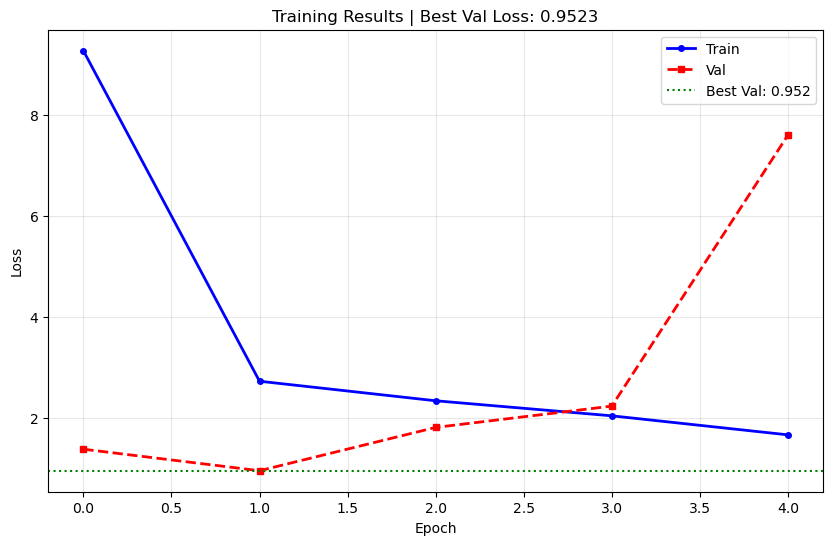

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, 'b-', linewidth=2, label='Train', marker='o', markersize=4)
plt.plot(val_losses, 'r--', linewidth=2, label='Val', marker='s', markersize=4)
plt.axhline(y=early_stopper.best_loss, color='g', linestyle=':', label=f'Best Val: {early_stopper.best_loss:.3f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Training Results | Best Val Loss: {early_stopper.best_loss:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
model.eval()
test_predictions = []

with torch.no_grad():
    for tabular, image, _ in test_loader:
        tabular, image = tabular.to(device), image.to(device)
        pred = model(tabular, image)
        test_predictions.extend(pred.cpu().numpy().flatten())

# Convert from log to dollars
test_predictions_dollars = np.expm1(test_predictions)

# Save to CSV
import pandas as pd
submission = pd.DataFrame({
    'property_id': range(len(test_predictions_dollars)),
    'predicted_price': test_predictions_dollars
})
submission.to_csv('test_predictions.csv', index=False)

print(f"✅ Predictions saved for {len(test_predictions_dollars)} test properties")
print(f"Sample predictions: {test_predictions_dollars[:5]}")

✅ Predictions saved for 5396 test properties
Sample predictions: [361580.1    21467.445  42630.63  149871.55   80561.86 ]


In [ ]:
# Test on a few validation samples
model.eval()
samples_to_check = 3

for i, (tabular, image, price) in enumerate(val_loader):
    if i >= 1:  # Just first batch
        break
    
    tabular, image, price = tabular.to(device), image.to(device), price.to(device)
    pred = model(tabular, image)
    
    for j in range(min(samples_to_check, batch_size)):
        pred_dollars = np.expm1(pred[j].item())
        actual_dollars = np.expm1(price[j].item())
        error = abs(pred_dollars - actual_dollars)
        error_pct = (error / actual_dollars) * 100
        
        print(f"Sample {j}: Pred ${pred_dollars:,.0f} | Actual ${actual_dollars:,.0f} | Error: ${error:,.0f} ({error_pct:.1f}%)")

In [ ]:
# CELL 10: Training Loop
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for tabular, image, price in loader:
        tabular, image, price = tabular.to(device), image.to(device), price.to(device)
        
        optimizer.zero_grad()
        pred = model(tabular, image)
        loss = criterion(pred, price)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for tabular, image, price in loader:
            tabular, image, price = tabular.to(device), image.to(device), price.to(device)
            pred = model(tabular, image)
            total_loss += criterion(pred, price).item()
    return total_loss / len(loader)

# epochs = 50
# train_losses, val_losses = [], []

# for epoch in range(epochs):
#     train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
#     val_loss = validate(model, val_loader, criterion, device)
    
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     scheduler.step(val_loss)
    
#     if epoch % 5 == 0:
#         print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")

# print("Training complete!")

# CELL 10: Training Loop with Early Stopping (UPDATED)
# epochs = 30  # Reduced
train_losses, val_losses = [], []

for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss) 
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}")
    
    # Early stopping
    if early_stopper(val_loss):
        print(f"Early stopping  at epoch {epoch}")
        break

print(f"Training complete! Best validation loss: {early_stopper.best_loss:.4f}")

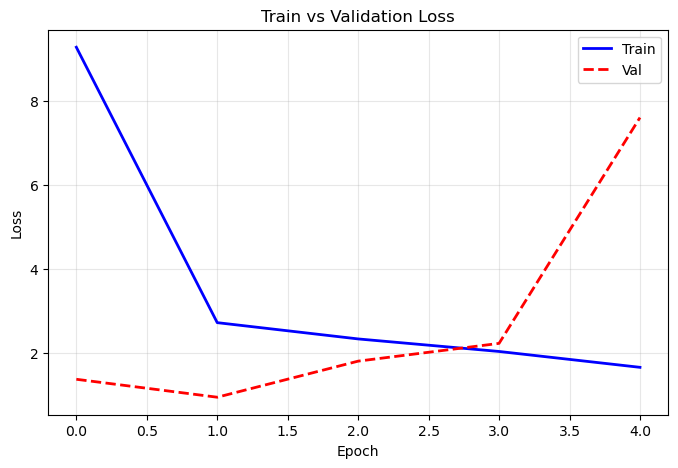

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, 'b-', linewidth=2, label='Train')
plt.plot(val_losses, 'r--', linewidth=2, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# CELL 11: Evaluate on Validation Set
model.eval()
val_predictions, val_actual = [], []

with torch.no_grad():
    for tabular, image, price in val_loader:
        tabular, image, price = tabular.to(device), image.to(device), price.to(device)
        pred = model(tabular, image)
        val_predictions.extend(pred.cpu().numpy().flatten())
        val_actual.extend(price.cpu().numpy().flatten())

val_predictions = np.array(val_predictions)
val_actual = np.array(val_actual)

# Convert from log price to actual price
# In CELL 11, update the conversion:
# Convert predictions from log price back to actual price
val_predictions_actual = np.expm1(val_predictions)   # Or just np.expm1() if you used log1p
val_actual_actual = np.expm1(val_actual)

rmse = np.sqrt(mean_squared_error(val_actual_actual, val_predictions_actual))
r2 = r2_score(val_actual_actual, val_predictions_actual)

print(f"Validation Results:")
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

In [ ]:
# CELL 12: Generate Test Predictions
model.eval()
test_predictions = []

with torch.no_grad():
    for tabular, image, _ in test_loader:
        tabular, image = tabular.to(device), image.to(device)
        pred = model(tabular, image)
        test_predictions.extend(pred.cpu().numpy().flatten())

test_predictions = np.array(test_predictions)
test_predictions_actual = np.expm1(test_predictions)

# Save predictions
pred_df = pd.DataFrame({
    'property_index': range(len(test_predictions_actual)),
    'predicted_price': test_predictions_actual
})
pred_df.to_csv('test_predictions.csv', index=False)

print(f"Test predictions saved for {len(test_predictions_actual)} properties")
print(f"Sample predictions: {test_predictions_actual[:5]}")

In [ ]:
# CELL 13: Save Model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'feature_names': feature_names,
    'scaler': scaler,
    'encoder': encoder
}, 'multimodal_property_model.pth')

print("Model saved to 'multimodal_property_model.pth'")